In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearnex import patch_sklearn, config_context
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
matlab_data = scipy.io.loadmat('D:\dts201\DTS201TC CW DATASET\PaviaU.mat')
print(matlab_data.keys())
paviaU_data = matlab_data['paviaU']

mat_label = scipy.io.loadmat('D:\dts201\DTS201TC CW DATASET\PaviaU_gt.mat')
paviaU_gt = mat_label["paviaU_gt"]

dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])


Text(0.5, 1.0, 'PaviaU Ground Truth Labels')

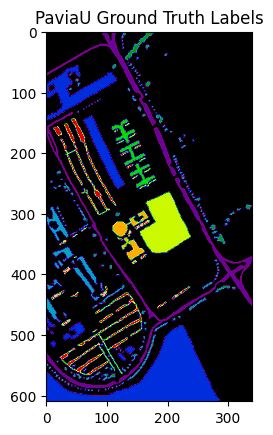

In [3]:
# Displaying the band of PaviaU data
plt.subplot(1, 2, 1)
plt.imshow(paviaU_gt, cmap='nipy_spectral')
plt.title("PaviaU Ground Truth Labels")

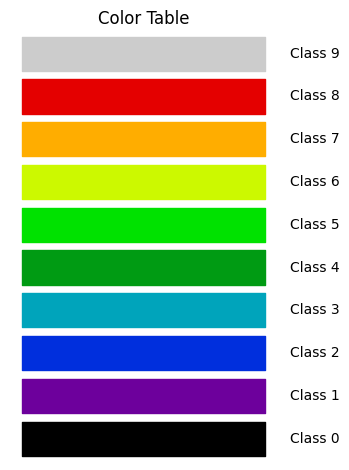

In [4]:
# Color table
unique_labels_all = np.unique(paviaU_gt)
colors_all = plt.cm.nipy_spectral(np.linspace(0, 1, len(unique_labels_all)))

plt.subplot(1, 2, 2)
for idx, (label, color) in enumerate(zip(unique_labels_all, colors_all)):
    plt.fill_between([0, 1], idx + 0.1, idx + 0.9, color=color)
    plt.text(1.1, idx + 0.5, f'Class {label}', va='center')
plt.ylim(0, len(unique_labels_all))
plt.axis('off')
plt.title("Color Table")

plt.tight_layout()
plt.show()

In [5]:
# Fisher's linear discriminant
# 610 vertical pixels,340 horizontal pixels, each pixel has 103 values for different bands or features
print('The shape of PaviaU: \n', paviaU_data.shape)

num_pixels = paviaU_data.shape[0] * paviaU_gt.shape[1]
print('The number of all pixels: ', num_pixels)
num_features = paviaU_data.shape[2]

The shape of PaviaU: 
 (610, 340, 103)
The number of all pixels:  207400


The best n_estimators are100,choose51features


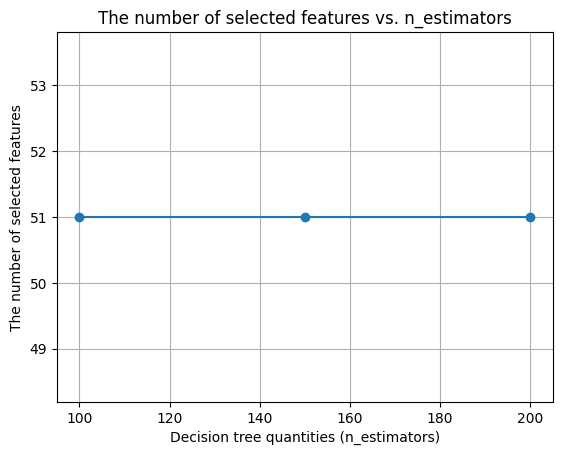

The shape of the filtered data is:  (42776, 51)
Mean values: [ 880.89610997  883.09664298  877.59224799  877.5243127   886.93138676
  898.75032729  895.49714793  897.91406396  905.67149804  913.7094165
  917.89667103  928.37296615  940.20703198  951.96727137  966.50091173
  982.89466056 1079.65604545 1112.03321956 1129.1351225  1137.57223677
 1181.06426501 1176.37829624 1171.65555452 1163.44707313 1266.61504114
 1332.93091921 1416.537147   1501.20871517 1580.49200486 2273.07169908
 2291.02889471 2280.31185712 2265.99350103 2295.00465214 2316.01830466
 2324.15071535 2322.41932392 2321.8837666  2342.78759117 2342.02438283
 2334.05309052 2339.11885169 2342.86284365 2331.71530765 2323.07352254
 2323.1718487  2317.27054891 2310.70820086 2304.37890406 2318.66242753
 2335.26613054]
Variance values: [435724.81336059 469999.40823074 498256.36964628 528150.69643526
 564984.7673373  601748.08844902 622639.57816654 649126.1327403
 673054.77865837 689336.94347407 699343.07366949 709738.57353885
 71

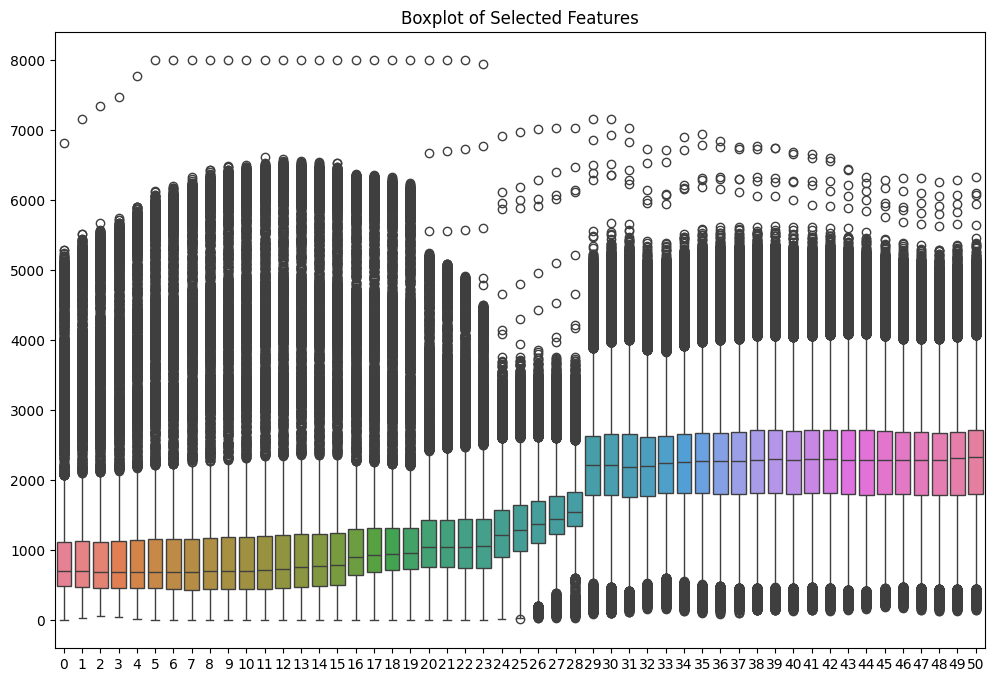

In [6]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
# Reshape the PaviaU data to be two-dimensional
paviaU_2D = paviaU_data.reshape((num_pixels, num_features))

# We will only take pixels where ground truth labels are not equal to zero
non_zero_labels = paviaU_gt.reshape(num_pixels) != 0
paviaU_2D_non_zero = paviaU_2D[non_zero_labels]

# Gets the label values of all pixels with non-zero labels and stores them in a one-dimensional array
paviaU_gt_non_zero = paviaU_gt.reshape(num_pixels)[non_zero_labels]

# Use random forest classifier to obtain feature importance
best_n_estimators = 100
best_num_features = 0
num_features_list = []
best_select_features = None

for n in range(100,201,50):
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(paviaU_2D_non_zero, paviaU_gt_non_zero)

    # Acquired feature importance
    feature_importance = rf.feature_importances_

    # Select a threshold for the feature
    threshold = np.median(feature_importance)

    # Select features based on thresholds
    selected_features = np.where(feature_importance > threshold)[0]

    num_features_list.append(len(selected_features))

    # Check whether the n_estimators give more selected features
    if len(selected_features) > best_num_features:
        best_num_features = len(selected_features)
        best_n_estimators = n
        best_select_features = selected_features

print(f"The best n_estimators are{best_n_estimators},choose{best_num_features}features")

# Visualize
plt.plot(range(100, 201, 50), num_features_list, marker='o', linestyle='-')
plt.xlabel('Decision tree quantities (n_estimators)')
plt.ylabel('The number of selected features')
plt.title('The number of selected features vs. n_estimators')
plt.grid(True)
plt.show()

# Filter the data to include only the selected features
paviaU_2D_non_zero = paviaU_2D_non_zero[:, best_select_features]
print('The shape of the filtered data is: ', paviaU_2D_non_zero.shape)

# Select the feature
mean_values = np.mean(paviaU_2D_non_zero, axis=0)
variance_values = np.var(paviaU_2D_non_zero, axis=0)
std_dev_values = np.std(paviaU_2D_non_zero, axis=0)

# Output statistic
print(f'Mean values: {mean_values}')
print(f'Variance values: {variance_values}')
print(f'Standard deviation values: {std_dev_values}')

# Draw a box plot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=paviaU_2D_non_zero)
plt.title('Boxplot of Selected Features')
plt.show()


# Normalization (converting features to a distribution with a mean of 0 and a standard deviation of 1)
scaler = StandardScaler()
paviaU_2D_non_zero = scaler.fit_transform(paviaU_2D_non_zero)


max_n_components = min(num_features, 51) 
PCA_dimensions = range(1, max_n_components + 1)

best_k_per_dimension = {}
max_accuracy_per_dimension = {}




In [7]:
from sklearn.decomposition import PCA

for n in PCA_dimensions:
        pca = PCA(n_components=n)
        X_PCA = pca.fit_transform(paviaU_2D_non_zero)

        # Split the data for training and test sets
        X_train, X_test, y_train, y_test = train_test_split(X_PCA, paviaU_gt_non_zero, test_size=0.3, random_state=51)

        k_values = range(1, 50)
        accuracies = []

        for k in k_values:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            accuracies.append(accuracy)

        # Find the k value for maximum accuracy
        max_accuracy = max(accuracies)
        best_k = k_values[accuracies.index(max_accuracy)]

        best_k_per_dimension[n] = best_k
        max_accuracy_per_dimension[n] = max_accuracy

# Find the PCA dimensionality with the highest accuracy
best_PCA_dimension = max(max_accuracy_per_dimension, key=max_accuracy_per_dimension.get)
best_k_for_best_dimension = best_k_per_dimension[best_PCA_dimension]

# Find the best accuracy
best_accuracy_for_best_dimension = max_accuracy_per_dimension[best_PCA_dimension]
print('The best dimension of PCA is ', best_PCA_dimension)
print(f'The best k of the best dimension {best_PCA_dimension} is {best_k_for_best_dimension}')
print(f'The best accuracy is {best_accuracy_for_best_dimension: .2%}')


The best dimension of PCA is  23
The best k of the best dimension 23 is 3
The best accuracy is  91.47%


In [8]:
from sklearn.decomposition import PCA
PCA_dimension = 33
pca = PCA(n_components=PCA_dimension)
X_PCA = pca.fit_transform(paviaU_2D_non_zero)

# Data segmentation
X_train, X_test, y_train, y_test = train_test_split(X_PCA, paviaU_gt_non_zero, test_size=0.3, random_state=51)

# The best K for a fixed value is 5
best_k = 5

# Start by looking for the best weights
weights_options = ['uniform', 'distance']
best_weights = None
best_accuracy_weights = 0

for weights in weights_options:
    knn = KNeighborsClassifier(n_neighbors=best_k, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy_weights:
        best_accuracy_weights = accuracy
        best_weights = weights

print(f"The best weights option is: {best_weights} with an accuracy of {best_accuracy_weights:.2%}")



The best weights option is: distance with an accuracy of 91.23%


In [9]:
# Use the best weights found to find the best metric
metric_options = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
best_metric = None
best_accuracy_metric = 0

for metric in metric_options:
    knn = KNeighborsClassifier(n_neighbors=best_k, weights=best_weights, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    if accuracy > best_accuracy_metric:
        best_accuracy_metric = accuracy
        best_metric = metric

print(f"The best metric option is: {best_metric} with an accuracy of {best_accuracy_metric:.2%}")

The best metric option is: manhattan with an accuracy of 91.49%


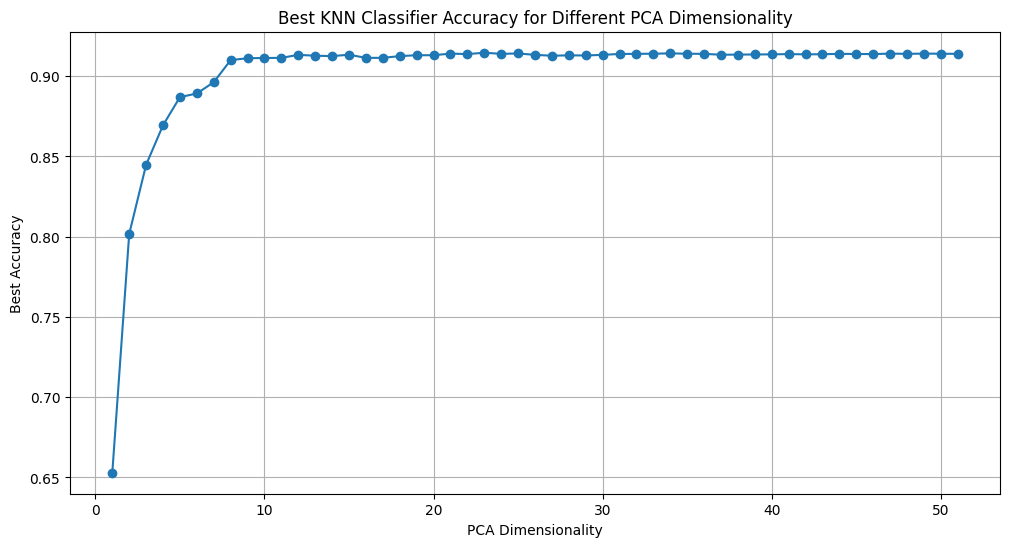

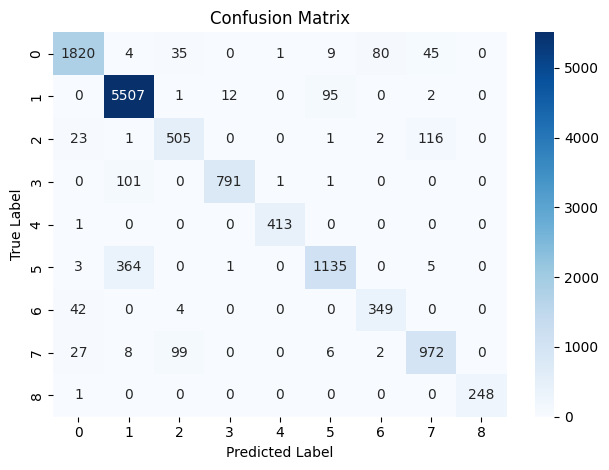

The classification report
               precision    recall  f1-score   support

           1       0.95      0.91      0.93      1994
           2       0.92      0.98      0.95      5617
           3       0.78      0.78      0.78       648
           4       0.98      0.88      0.93       894
           5       1.00      1.00      1.00       414
           6       0.91      0.75      0.82      1508
           7       0.81      0.88      0.84       395
           8       0.85      0.87      0.86      1114
           9       1.00      1.00      1.00       249

    accuracy                           0.91     12833
   macro avg       0.91      0.90      0.90     12833
weighted avg       0.92      0.91      0.91     12833



In [10]:
# Train the KNN classifier with the best k value for the best LDA dimension

pca_best = PCA(n_components=best_PCA_dimension)
X_PCA_best = pca_best.fit_transform(paviaU_2D_non_zero)
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_PCA_best, paviaU_gt_non_zero, test_size=0.3,
                                                                        random_state=42)
knn_best = KNeighborsClassifier(n_neighbors=best_k_for_best_dimension, weights='distance', metric='manhattan')
knn_best.fit(X_train_best, y_train_best)
y_pred_best = knn_best.predict(X_test_best)

# Plotting the accuracies for different LDA dimensions
plt.figure(figsize=(12, 6))
plt.plot(list(max_accuracy_per_dimension.keys()), list(max_accuracy_per_dimension.values()), marker='o', linestyle='-')
plt.title('Best KNN Classifier Accuracy for Different PCA Dimensionality')
plt.xlabel('PCA Dimensionality')
plt.ylabel('Best Accuracy')
plt.grid(True)
plt.show()

# Calculate confusion matrix and classification report for the best LDA dimension
conf_mat_best = confusion_matrix(y_test_best, y_pred_best)
report_best = classification_report(y_test_best, y_pred_best)
sns.heatmap(conf_mat_best, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print('The classification report\n',report_best)